#### **1. 设置环境**

导入 Python 标准库、第三方库和本项目自定义库

In [1]:
# 标准库
import os
import sys

# 第三方库
# pip install seaborn matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

# 将上级目录加入系统路径
# 以便导入项目自定义库
sys.path.append(os.path.abspath('..'))

# 自定义库
# 译文相似度计算模块
from src.analyzer.mt_similarity_analysis import MTSimilarityAnalyzer

#### **2. 读取数据**

读取包含人工译文和大模型译文的多版本平行语料库

In [2]:
# 指定路径
data_file = '../data/output/0_mt_generation.jsonl'
print(f"从 {data_file} 文件读取数据 ...")

# 读取数据
analyzer = MTSimilarityAnalyzer(data_file)
analyzer.load_data()
print(f"成功读取 {len(next(iter(analyzer.data_map.values())))} 条句对")
print(f"译文版本：{analyzer.versions}\n")

# 预览数据
print(f"数据示例：\n[Source]\n{analyzer.source_list[0]}\n")
for k, v in analyzer.data_map.items():
    print(f"[{k.capitalize()}]\n{v[0]}\n")

从 ../data/output/0_mt_generation.jsonl 文件读取数据 ...
成功读取 300 条句对
译文版本：['human', 'deepseek-v3.2', 'qwen3-max']

数据示例：
[Source]
江南近海滨的一条大路上，一队清兵手执刀枪，押着七辆囚车，冲风冒寒，向北而行。

[Human]
Along a coastal road somewhere south of the Yangtze River, a detachment of soldiers, each of them armed with a halberd, was escorting a line of seven prison carts, trudging northwards in the teeth of a bitter wind.

[Deepseek-v3.2]
Along a broad road near the coast south of the Yangtze River, a troop of Qing soldiers, armed with swords and spears, escorted seven prison carts northward, braving the biting wind and cold.

[Qwen3-max]
On a major road near the coast in Jiangnan, a squad of Qing soldiers, armed with swords and spears, escorted seven prison carts northward through biting wind and bitter cold.



#### **3. 分析数据**

计算各译文版本间的表层形式相似度和深层语义相似度

In [3]:
# === 计算表层形式相似度 ===

# 相似度算法基于最长公共子串：
# https://docs.python.org/3/library/difflib.html#difflib.SequenceMatcher.ratio
# 计算公式：str_sim(A, B) = 2 * M / (len(A) + len(B))
# 其中：
# M = 两个字符串中的最长公共连续子串长度
# len(A) = 文本 A 的长度
# len(B) = 文本 B 的长度

# str_sim 取值范围：(0, 1)
# str_sim 越大，相似度越高

# 例如：
# A = "abcd"，B = "abed"
# 最长公共连续子串为：ab，d
# 因此，M = 3
# len(A) + len(b) = 4 + 4 = 8
# 文本相似度 = 2 * 3 / 8 = 0.75

print("计算表层形式相似度 ...")
df_str_sim = analyzer.get_string_similarity_matrix()
print(f"计算完成！译文相似度矩阵如下：\n{df_str_sim}\n")

计算表层形式相似度 ...
计算完成！译文相似度矩阵如下：
                  human  deepseek-v3.2  qwen3-max
human          1.000000       0.347471   0.341414
deepseek-v3.2  0.347471       1.000000   0.647697
qwen3-max      0.341414       0.647697   1.000000



In [4]:
# === 计算深层语义相似度 ===

# 文本向量化基于 Sentence-Transformers：https://www.sbert.net/
# 首次运行会自动下载句向量模型：all-MiniLM-L6-v2
# https://www.sbert.net/docs/sentence_transformer/pretrained_models.html
# 模型大小：约 80M

# 相似度算法基于余弦相似度：
# https://sbert.net/docs/sentence_transformer/usage/semantic_textual_similarity.html
# 计算公式：cos_sim(A, B) = (emb(A) · emb(B)) / (||emb(A)|| * ||emb(B)||)
# 其中：
# emb(A)和 emb(B) 为文本向量（基于 all-MiniLM-L6-v2 模型）
# emb(A) · emb(B) 为向量点积
# ||emb(A)|| *  ||emb(B)|| 为向量模长的乘积

# 余弦相似度反映两个向量在语义空间中的夹角大小：
# cos_sim ≈ 1  ——  语义非常相近
# cos_sim ≈ 0  ——  语义无相关
# cos_sim < 0  ——  语义相反（在句向量中较少出现）

print("计算深层语义相似度相似度 ...")
df_sem_sim = analyzer.get_embedding_similarity_matrix()
print(f"计算完成！译文相似度矩阵如下：\n{df_sem_sim}")

计算深层语义相似度相似度 ...
计算完成！译文相似度矩阵如下：
                  human  deepseek-v3.2  qwen3-max
human          1.000000       0.629036   0.617905
deepseek-v3.2  0.629036       1.000000   0.872390
qwen3-max      0.617905       0.872390   1.000000


#### **4. 绘制图表**

绘制热力图，直观展示各版本译文间的相似度差异

In [5]:
# 设置绘图风格
font_name = 'Microsoft YaHei'
sns.set_theme(style="white", font=font_name) 

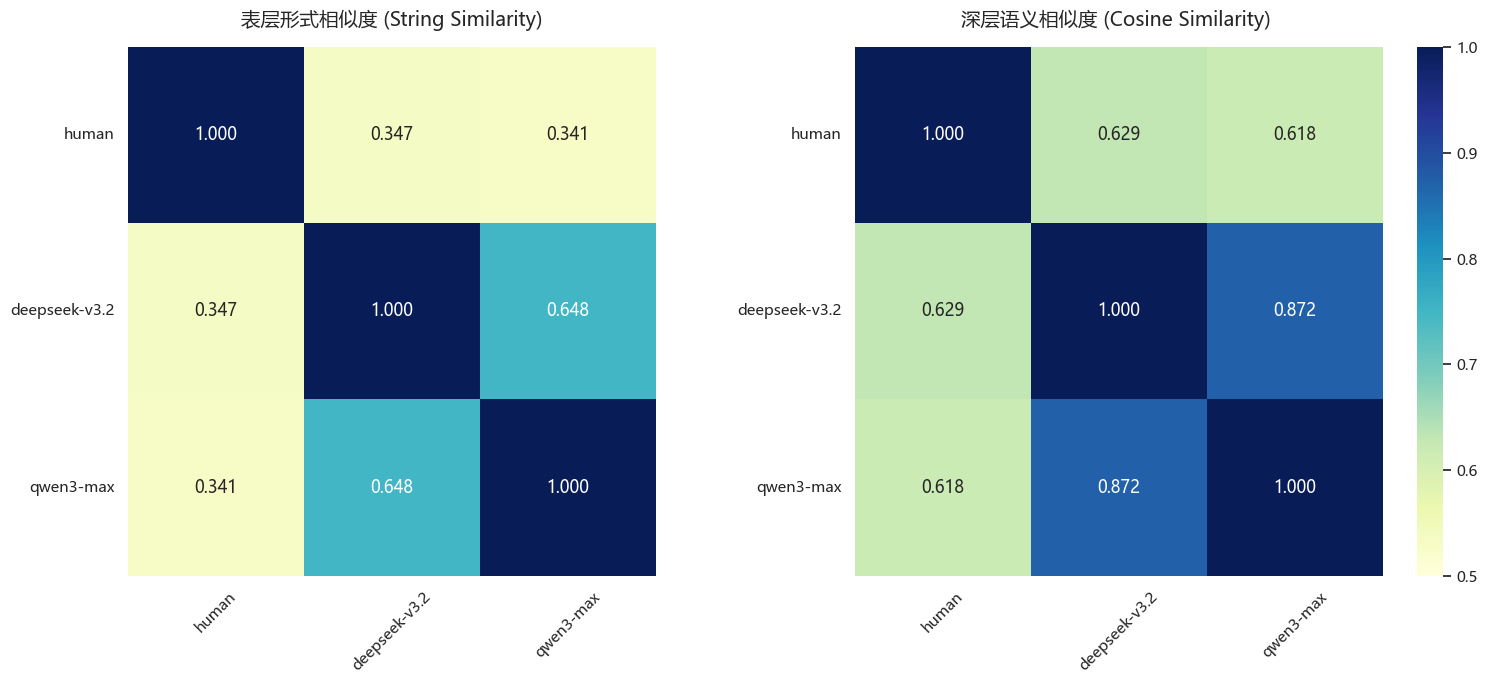

In [6]:
# 创建画布
fig, ax = plt.subplots(1, 2, figsize=(16, 7))

# 统一色调
cmap = "YlGnBu"

# --- 图 1: 表层形式相似度  ---
sns.heatmap(df_str_sim, annot=True, fmt=".3f", cmap=cmap, vmin=0.3, vmax=1.0, 
            ax=ax[0], cbar=False, square=True, annot_kws={"size": 12})
ax[0].set_title("表层形式相似度 (String Similarity)", fontsize=14, pad=15)
ax[0].tick_params(axis='x', rotation=45)
ax[0].tick_params(axis='y', rotation=0)

# --- 图 2: 深层语义相似度 ---
sns.heatmap(df_sem_sim, annot=True, fmt=".3f", cmap=cmap, vmin=0.5, vmax=1.0, 
            ax=ax[1], cbar=True, square=True, annot_kws={"size": 12})
ax[1].set_title("深层语义相似度 (Cosine Similarity) ", fontsize=14, pad=15)
ax[1].tick_params(axis='x', rotation=45)
ax[1].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()

#### **5. 提取例句**

提取机器译文和人工译文之间相似度差异最大的例句

In [16]:
# 指定译文版本
ver_a = 'human'
ver_b = 'deepseek-v3.2'

In [14]:
# --- 提取表层形式相似度差异最大的例句 ---

# 指定相似度指标
metric = 'string'

# 提取例句
diffs_str = analyzer.get_divergent_examples(
    ver_a=ver_a, 
    ver_b=ver_b, 
    metric=metric, 
)

# 打印例句
analyzer.print_divergence(diffs_str, "表层形式 (String)", ver_a, ver_b) 


=== 表层形式 (String) 相似度最低的例句  Top 3 ===

[1] ID: 000130 | Sim Score: 0.0132
原文: 只觉天涯茫茫，到处是鞑子的天下，真无一片干净土地，沉吟道：“桃源何处，可避暴秦？
------------------------------------------------------------
Human: The whole world belonged to the Tartars now, it seemed. Not a single patch of land was free of their hated presence. He thought of the poet Tao Yuanming's story about the fisherman who, by following a stream that flowed between flowering peach trees, had stumbled on an earthly paradise—a place where refugees from ancient tyranny had found a haven.
Deepseek-v3.2: I feel as though the world is vast and boundless, yet everywhere is under the Tartars' dominion—truly, there is not a single clean patch of land left. I murmured to myself, 'Where is the Peach Blossom Spring where one might escape the tyranny of the Qin?'

[2] ID: 000050 | Sim Score: 0.0146
原文: 忽见南边大道上两个人戴着斗笠，并肩而来，走到近处，认出了面貌。 那文士大喜，道：“是你黄伯伯、顾伯伯来了！” 快步迎将出去，叫道：“梨洲兄、亭林兄，哪一阵好风，吹得你二位光临？”
------------------------------------------------------------


In [21]:
# --- 提取深层语义相似度差异最大的例句 ---

# 指定相似度指标
metric = 'semantic'

# 提取例句
diffs_sem = analyzer.get_divergent_examples(
    ver_a=ver_a, 
    ver_b=ver_b, 
    metric=metric, 
)

# 打印例句
analyzer.print_divergence(diffs_sem, "深层语义 (Semantic)", ver_a, ver_b)


=== 深层语义 (Semantic) 相似度最低的例句  Top 3 ===

[1] ID: 000290 | Sim Score: 0.1851
原文: 咱们骑驴看唱本，走着瞧，韦小宝总不会折在你臭小娘手里。”
------------------------------------------------------------
Human: 'As the man reading the songbook while he rode his mule said, "We'll work something out as we go along,"' he thought: 'Old Trink's not going to be beaten by a smelly little girl like you.'
Deepseek-v3.2: Let's wait and see how this plays out. I, Wei Xiaobao, will certainly not be brought down by a little wench like you.

[2] ID: 000209 | Sim Score: 0.1955
原文: 你胆大妄为，难道我胆子就小了？”
------------------------------------------------------------
Human: Well, Mister Butcher Qian, if you had the nerve to kidnap her and smuggle her into the Palace, I suppose I ought to have the nerve to keep her here.'
Deepseek-v3.2: "You are bold and reckless, but does that mean I am timid?"

[3] ID: 000103 | Sim Score: 0.1974
原文: 不知究竟如何？”
------------------------------------------------------------
Human: What was it, exactly, that brough